# Gaussian Mixture Models and EM algorithm from scratch 

This is the implementation of GMM and EM from scratch in Python. Here is the video by Siraj Raval to learn more about this algorithms. https://www.youtube.com/redirect?q=https%3A%2F%2Fgithub.com%2FllSourcell%2FGaussian_Mixture_Models&redir_token=9_5Mf2786fmCyQ87Q5Yq5jocsMx8MTUzMzQ4NTg1M0AxNTMzMzk5NDUz&event=video_description&v=JNlEIEwe-Cg 

Some more resources and codes can be found in the video description  as well as in the following links. 

1. https://github.com/benathi/word2gm
2. https://github.com/GaborLengyel/Finite-Gaussian-Mixture-models/blob/master/Finite%20Gaussian%20Mixture%20models.ipynb
3. https://www.youtube.com/redirect?q=http%3A%2F%2Fyulearning.blogspot.nl%2F2014%2F11%2Feinsteins-most-famous-equation-is-emc2.html&redir_token=9_5Mf2786fmCyQ87Q5Yq5jocsMx8MTUzMzQ4NTg1M0AxNTMzMzk5NDUz&event=video_description&v=JNlEIEwe-Cg
4. https://www.youtube.com/redirect?q=http%3A%2F%2Fweb.iitd.ac.in%2F%7Esumeet%2FGMM_said_crv10_tutorial.pdf&redir_token=9_5Mf2786fmCyQ87Q5Yq5jocsMx8MTUzMzQ4NTg1M0AxNTMzMzk5NDUz&event=video_description&v=JNlEIEwe-Cg
5. https://www.youtube.com/redirect?q=http%3A%2F%2Fwww.vlfeat.org%2Foverview%2Fgmm.html&redir_token=9_5Mf2786fmCyQ87Q5Yq5jocsMx8MTUzMzQ4NTg1M0AxNTMzMzk5NDUz&event=video_description&v=JNlEIEwe-Cg 

So let's get started. 

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats
sns.set_style("white")
%matplotlib inline 

In [8]:
# Read our dataset 
df = pd.read_csv('bimodal_example.csv')
# First five rows of data 
print(df.head())

          x
0  0.252851
1 -1.034562
2  3.319558
3  4.552363
4 -0.775995


In [9]:
# Let's take the x as our input to the model 
data = df.x 

/home/urvish/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


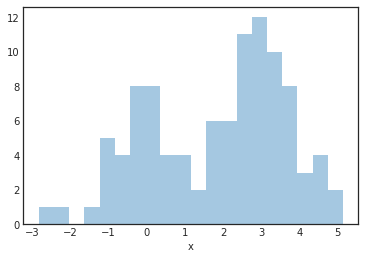

In [10]:
sns.distplot(data, bins=20, kde=False)

Now let's see if we can fit normal distribution on top of it. 

/home/urvish/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


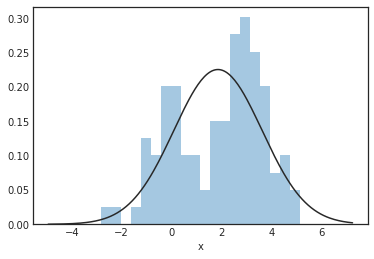

In [11]:
sns.distplot(data, fit=stats.norm, bins=20, kde=False)

In [14]:
# Define our model 
class Gaussian:
    "Model Univariate Gaussian"
    def __init__(self, mu, sigma):
        #Mean and standard deviation 
        self.mu = mu 
        self.sigma = sigma
        
    def pdf(self, datum):
        "Probability of a data point given the current param"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u /2)
        return y 
    #Printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [15]:
# Guassian of best fit 
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: mu = {:.2}, sigma = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: mu = 1.9, sigma = 1.8


/home/urvish/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


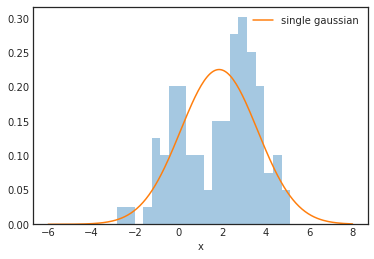

In [18]:
# Fit a single guassian on the data 
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [19]:
from math import sqrt, log, exp, pi
from random import uniform

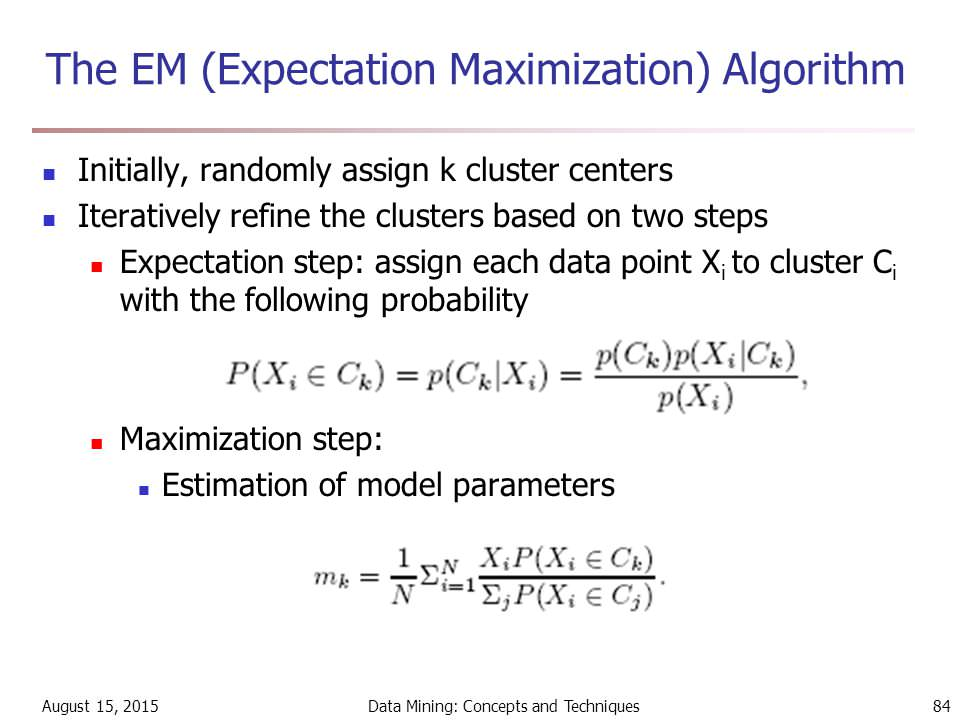

In [26]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike


    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [27]:
# Check out the process 
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning):
        # Catch division errors from bad starts, and just throw them out...
        pass


 1 Mixture: Gaussian(0.867114, 0.829253), Gaussian(2.30043, 1.89245), mix=0.305)
 1 Mixture: Gaussian(0.644148, 1.08614), Gaussian(2.21862, 1.77311), mix=0.226)
 1 Mixture: Gaussian(0.414386, 1.2513), Gaussian(2.22993, 1.6925), mix=0.202)
 1 Mixture: Gaussian(0.186136, 1.33952), Gaussian(2.27231, 1.61447), mix=0.196)
 1 Mixture: Gaussian(-0.00754107, 1.32825), Gaussian(2.32702, 1.54592), mix=0.199)


In [28]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



Done. 🙂


/home/urvish/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


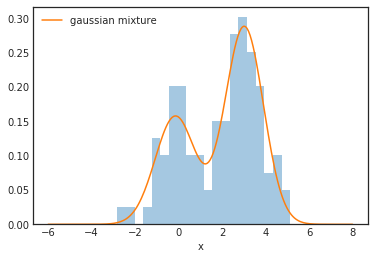

In [29]:
#mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

### Summary
* Gaussian Mixture Models (GMM) take our old friend the Gaussian and add another Gaussian(s).
* This allows us to model more complex data.
* We fit a GMM with the Expectation–Maximization (EM) Algorithm.
* Expectation–Maximization (EM) Algorithm is a series of steps to find good parameter estimates when there are latent variables.
* EM steps:
    1. Initialize the parameter estimates
    2. Given the current parameter estimates, find the min log likelihood for Z (data+latent variables)
    3. Given the current data, find better parameter estimates

* Repeat steps 2 & 3
* EM can be used beyond GMM
* GMM work well but you have to guess the number of Gaussians. Kernel Density Estimation (KDE) does not require that kind of guessing